In [95]:
# import the required libraries
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path
from PIL import Image
from torchvision import transforms, utils

from data_load import *

import cv2

%load_ext autoreload
%autoreload 2

## raw data

### files

So there are some training and testing images and their keypoints:

- we have `3462` training images and `2308` testing images; it looks like we have multiple images for each person; no validation set;
- we have `68` keypoints for each image that are represented as `2D` points: `(x, y)`;

In [3]:
data_dir = Path.home()/'data/facial_keypoints/'

In [5]:
ls ~/data/facial_keypoints/

test/                          training/
test_frames_keypoints.csv      training_frames_keypoints.csv


In [11]:
ls ~/data/facial_keypoints/training | head -20

Abdel_Aziz_Al-Hakim_00.jpg
Abdel_Aziz_Al-Hakim_01.jpg
Abdel_Aziz_Al-Hakim_02.jpg
Abdel_Aziz_Al-Hakim_10.jpg
Abdel_Aziz_Al-Hakim_11.jpg
Abdel_Aziz_Al-Hakim_12.jpg
Abdel_Aziz_Al-Hakim_40.jpg
Abdel_Aziz_Al-Hakim_41.jpg
Abdel_Aziz_Al-Hakim_42.jpg
Abdullah_Gul_10.jpg
Abdullah_Gul_11.jpg
Abdullah_Gul_12.jpg
Abdullah_Gul_30.jpg
Abdullah_Gul_31.jpg
Abdullah_Gul_32.jpg
Abdullah_Gul_50.jpg
Abdullah_Gul_51.jpg
Abdullah_Gul_52.jpg
Adam_Sandler_00.jpg
Adam_Sandler_01.jpg


In [14]:
ls ~/data/facial_keypoints/training | wc -l

    3462


In [15]:
ls ~/data/facial_keypoints/test | wc -l

    2308


In [16]:
df = pd.read_csv(data_dir/'training_frames_keypoints.csv')

In [18]:
df.shape

(3462, 137)

In [20]:
68 * 2 + 1

137

In [17]:
df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


In [53]:
img_idx = 100

### keypoints

In [54]:
image_name = df.iloc[img_idx, 0]

In [55]:
image_name

'Leszek_Miller_01.jpg'

In [56]:
key_pts = df.iloc[img_idx, 1:].values

In [57]:
type(key_pts), key_pts.shape, key_pts.dtype

(numpy.ndarray, (136,), dtype('O'))

In [58]:
key_pts = key_pts.astype('float')

In [59]:
key_pts.dtype

dtype('float64')

In [60]:
key_pts = key_pts.reshape(68, 2)

In [61]:
key_pts.shape

(68, 2)

### how to read an image?

We may read an image using:

- `matplotlib.pyplot` using `imread()` (or with `matplotlib.image`);
- `cv2` using `imread()`; as we can see - not the best option;
- `Pillow` using `Image.open()`;

We may read in documentation:

> Matplotlib can only read PNGs natively. Further image formats are supported via the optional dependency on Pillow. Note, URL strings are not compatible with Pillow. Check the Pillow documentation for more information.

In [62]:
image_file = os.path.join(data_dir / 'training', image_name)

In [63]:
image_file

'/Users/ilyarudyak/data/facial_keypoints/training/Leszek_Miller_01.jpg'

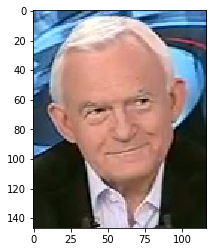

In [64]:
img = plt.imread(image_file)
plt.imshow(img);

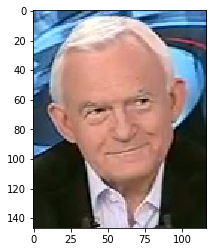

In [65]:
img = mpimg.imread(image_file)
plt.imshow(img);

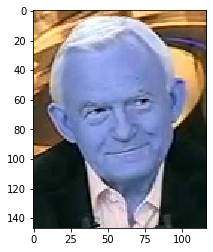

In [66]:
img = cv2.imread(image_file)
plt.imshow(img);

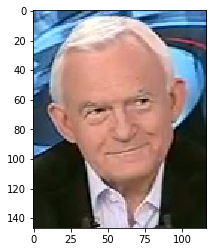

In [67]:
img = Image.open(image_file)
plt.imshow(img);

### visualize an image

Let's now visialize keypoints on an image. It looks like that coordinates of points in `key_points` are consistent with axes that we may see on an image.

In [78]:
# s is a marker size
def show_keypoints(image, key_pts):
    """Show image with keypoints"""
    plt.imshow(image)
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')

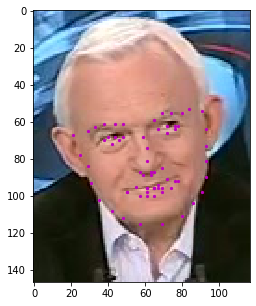

In [74]:
plt.figure(figsize=(5, 5))
show_keypoints(img, key_pts)

In [77]:
key_pts[:3, :]

array([[21., 67.],
       [25., 78.],
       [29., 84.]])

## dataset

Our `Dataset` is a subclass of `torch.utils.data.Dataset` as usual (we use internal `df` like above to get all the information):

- we may get its length;
- we may get a sample - dictionary that contains an image and its keypoints;
- we can also provide `transforms`;

In [81]:
dataset = FacialKeypointsDataset(csv_file=data_dir/'training_frames_keypoints.csv',
                                 root_dir=data_dir/'training/')

In [82]:
dataset.key_pts_frame.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


In [83]:
dataset.key_pts_frame.shape

(3462, 137)

In [84]:
len(dataset)

3462

In [86]:
sample = dataset[img_idx]

In [87]:
sample.keys()

dict_keys(['image', 'keypoints'])

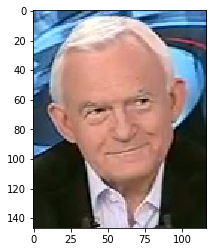

In [88]:
plt.imshow(sample['image']);

In [89]:
sample['keypoints'].shape

(68, 2)

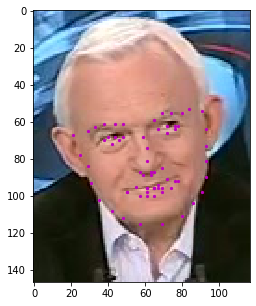

In [90]:
plt.figure(figsize=(5, 5))
show_keypoints(sample['image'], sample['keypoints'])

## transforms

They use custom transformations classes in this assignment (that resemples `pytorch` classes) - they use samples (contain both image and key points), not only images.

They also convert images to grayscale. It's not directly mentioned in the provided paper but it seems they also use grayscale images.

In [105]:
train_transform = transforms.Compose([Rescale(250),
                                      RandomCrop(224),
#                                       Normalize(),
#                                      ToTensor()
                                     ])

transformed_dataset = FacialKeypointsDataset(csv_file=data_dir/'training_frames_keypoints.csv',
                                             root_dir=data_dir/'training/',
                                             transform=train_transform)

In [106]:
transformed_sample = transformed_dataset[img_idx]

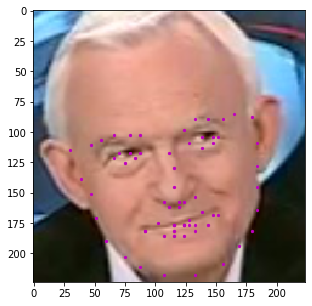

In [107]:
plt.figure(figsize=(5, 5))
show_keypoints(transformed_sample['image'], transformed_sample['keypoints'])

In [108]:
train_transform = transforms.Compose([Rescale(250),
                                      RandomCrop(224),
                                      Normalize(),
                                     ToTensor()
                                     ])

transformed_dataset = FacialKeypointsDataset(csv_file=data_dir/'training_frames_keypoints.csv',
                                             root_dir=data_dir/'training/',
                                             transform=train_transform)